In [193]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [194]:
import numpy as np
import pandas as pd

In [195]:
df = pd.read_csv('creditcard.csv')

In [196]:
df['dummy_col'] = 0

In [197]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,dummy_col
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [198]:
df_train = df.iloc[:227845]

In [199]:
X = df_train.drop(['Time', 'Class'], axis = 1).values
y = df_train['Class'].values

In [200]:
from sklearn.model_selection import train_test_split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [202]:
from imblearn.over_sampling import SMOTE

In [203]:
sm = SMOTE()

In [204]:
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

In [205]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_bal.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_bal.shape))
# now the major and minor classes gets balanced equally
print("After OverSampling, counts of label '1': {}".format(sum(y_train_bal==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_bal==0)))

After OverSampling, the shape of train_X: (318390, 30)
After OverSampling, the shape of train_y: (318390,) 

After OverSampling, counts of label '1': 159195
After OverSampling, counts of label '0': 159195


In [206]:
from sklearn.preprocessing import StandardScaler

In [207]:
scaler = StandardScaler()

In [208]:
X_train_bal = scaler.fit_transform(X_train_bal)

In [209]:
X_test = scaler.transform(X_test)

In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [211]:
model = Sequential()

model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(15, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [212]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 15)

In [213]:
model.fit(x = X_train_bal, y = y_train_bal, epochs = 500, batch_size = 128, validation_data = (X_test, y_test), callbacks = [early_stop])

Train on 318390 samples, validate on 68354 samples
Epoch 1/500
318390/318390 [==============================] - 8s 24us/sample - loss: 0.1515 - val_loss: 0.0318
Epoch 2/500
318390/318390 [==============================] - 7s 21us/sample - loss: 0.0511 - val_loss: 0.0243
Epoch 3/500
318390/318390 [==============================] - 7s 21us/sample - loss: 0.0321 - val_loss: 0.0187
Epoch 4/500
318390/318390 [==============================] - 7s 22us/sample - loss: 0.0266 - val_loss: 0.0140
Epoch 5/500
318390/318390 [==============================] - 7s 22us/sample - loss: 0.0249 - val_loss: 0.0140
Epoch 6/500
318390/318390 [==============================] - 7s 21us/sample - loss: 0.0217 - val_loss: 0.0136
Epoch 7/500
318390/318390 [==============================] - 7s 22us/sample - loss: 0.0209 - val_loss: 0.0157
Epoch 8/500
318390/318390 [==============================] - 7s 22us/sample - loss: 0.0210 - val_loss: 0.0136
Epoch 9/500
318390/318390 [==============================] - 7s 22us/

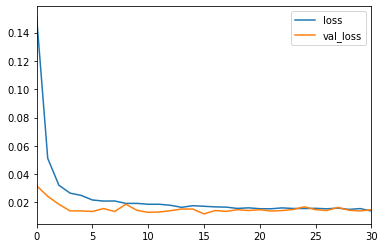

In [214]:
pd.DataFrame(model.history.history).plot()

In [215]:
predictions = model.predict_classes(X_test)

In [216]:
from sklearn.metrics import confusion_matrix, classification_report

In [217]:
print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))      # NN validation metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68233
           1       0.63      0.80      0.71       121

    accuracy                           1.00     68354
   macro avg       0.82      0.90      0.85     68354
weighted avg       1.00      1.00      1.00     68354



[[68177    56]
 [   24    97]]


In [218]:
df_test = df[227845:]

In [219]:
X_test_final = df_test.drop(['Class', 'Time'], axis = 1)
y_test_final = df_test['Class']

In [220]:
X_test_final = scaler.transform(X_test_final)

In [221]:
predictions_final = model.predict_classes(X_test_final)

In [222]:
print(classification_report(y_test_final, predictions_final))
print('\n')
print(confusion_matrix(y_test_final, predictions_final))      # NN final test metrics after balancing

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.64      0.81      0.72        75

    accuracy                           1.00     56962
   macro avg       0.82      0.91      0.86     56962
weighted avg       1.00      1.00      1.00     56962



[[56853    34]
 [   14    61]]
